In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 # for image resizing
import numpy as np
import pandas as pd

%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
print(tf.__version__)

Using TensorFlow backend.


1.10.0


In [2]:
import glob
import h5py
import shutil
import imgaug as aug
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("./chest_xray/"))

['.DS_Store', 'test', 'train', 'val']


In [12]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(87)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(87)

# Make the augmentation sequence deterministic
aug.seed(87)

In [13]:
# Define path to the data directory
data_dir = Path('./chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [56]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

for img in normal_cases:
    train_data.append((img,0))

for img in pneumonia_cases:
    train_data.append((img,1))

train_data = pd.DataFrame(train_data, columns=['image','label'],index = None)

train_data = train_data.sample(frac=1.).reset_index(drop=True)


cases_count = train_data['label'].value_counts()
print(cases_count)

train_data.head()


1    3875
0    1341
Name: label, dtype: int64


,image,label
0,chest_xray\train\NORMAL\IM-0584-0001.jpeg,0
1,chest_xray\train\NORMAL\NORMAL2-IM-0423-0001.jpeg,0
2,chest_xray\train\PNEUMONIA\person1463_bacteria...,1
3,chest_xray\train\PNEUMONIA\person1467_virus_25...,1
4,chest_xray\train\PNEUMONIA\person1052_virus_17...,1


In [57]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 128, 128, 3)
Total number of labels: (16, 2)


In [58]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [67]:
def data_gen(data, batch_size, imsize):
    n = len(data)
    steps = n//batch_size
    
    batch_data = np.zeros((batch_size,imsize,imsize,3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)
    
    indices = np.arange(n)
    
    i=0
    while True:
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j,idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            #onde hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (imsize,imsize))
            
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            if label == 0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.
                
                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count+=2
            else:
                count+=1
                
            if count == batch_size-1:
                break
        i+=1
        yield batch_data, batch_labels
        
        if i>=steps:
            i=0

In [68]:
def build_128_model():
    input_img = Input(shape=(128,128,3), name='ImageInput')
    x = Conv2D(filters=16, kernel_size=(3,3), activation="relu",padding="same", name="Conv1_1")(input_img)
    x = Conv2D(filters=16, kernel_size=(3,3), activation="relu",padding="same", name="Conv1_2")(x)
    x = BatchNormalization(name="bn_1")(x)
    x = MaxPooling2D(pool_size=(2,2),name="pool_1")(x)
    x = Dropout(rate=0.2)(x)
    
    x = Conv2D(filters=32, kernel_size=(3,3), activation="relu",padding="same", name="Conv2_1")(x)
    x = Conv2D(filters=32, kernel_size=(3,3), activation="relu",padding="same", name="Conv2_2")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = MaxPooling2D(pool_size=(2,2),name="pool_2")(x)
    x = Dropout(rate=0.2)(x)
    
    x = Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same", name="Conv3_1")(x)
    x = Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same", name="Conv3_2")(x)
    x = BatchNormalization(name="bn_3")(x)
    x = MaxPooling2D(pool_size=(2,2),name="pool_3")(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(512,activation="relu", name="fc_1")(x)
    x = BatchNormalization(name="bn_4")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(256,activation="relu", name="fc_2")(x)
    x = BatchNormalization(name="bn_5")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(2,activation="softmax",name="fc_3")(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model    

In [69]:
model_128 = build_128_model()
model_128.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 128, 128, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 16)      448       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 128, 128, 16)      2320      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 128, 128, 16)      64        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 64, 64, 32)        4640      
__________

In [70]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model_128.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [71]:
batch_size = 16
nb_epochs = 20

train_data_gen = data_gen(data=train_data, batch_size=batch_size, imsize=128)
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [72]:
gen = ImageDataGenerator()
valid_batches = gen.flow_from_directory("chest_xray/val", model_128.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)

Found 16 images belonging to 2 classes.


In [78]:
hist_128 = model_128.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(valid_data, valid_labels) , callbacks=[es,chkpt])

Epoch 1/20
326/326 [==============================] - 69s 212ms/step - loss: 0.0583 - acc: 0.9818 - val_loss: 1.8072 - val_acc: 0.5625
Epoch 2/20
326/326 [==============================] - 69s 212ms/step - loss: 0.0596 - acc: 0.9793 - val_loss: 0.7763 - val_acc: 0.7500
Epoch 3/20
326/326 [==============================] - 67s 207ms/step - loss: 0.0534 - acc: 0.9833 - val_loss: 1.3747 - val_acc: 0.5625
Epoch 4/20
326/326 [==============================] - 68s 209ms/step - loss: 0.0641 - acc: 0.9781 - val_loss: 0.4663 - val_acc: 0.8125
Epoch 5/20
326/326 [==============================] - 69s 210ms/step - loss: 0.0687 - acc: 0.9793 - val_loss: 0.9819 - val_acc: 0.8125
Epoch 6/20
326/326 [==============================] - 70s 214ms/step - loss: 0.0569 - acc: 0.9822 - val_loss: 0.2309 - val_acc: 0.8750
Epoch 7/20
326/326 [==============================] - 67s 206ms/step - loss: 0.0511 - acc: 0.9866 - val_loss: 0.8941 - val_acc: 0.6875
Epoch 8/20
326/326 [==============================] - 6

In [79]:
model_128.load_weights("best_model_todate")

In [80]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 128, 128, 3)
Total number of labels: (624, 2)


In [81]:
# Evaluation on test dataset
test_loss, test_score = model_128.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 1s 1ms/step
Loss on test set:  1.173952668516181
Accuracy on test set:  0.7900641025641025


In [82]:
# Get predictions
preds = model_128.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

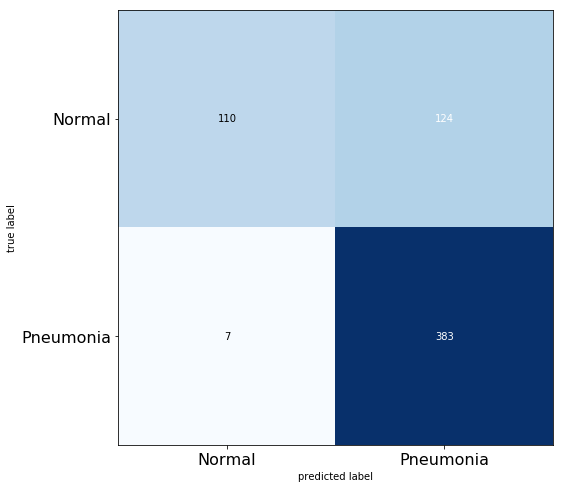

In [84]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [85]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.76


In [86]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data_64 = []
valid_labels_64 = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data_64.append(img)
    valid_labels_64.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data_64.append(img)
    valid_labels_64.append(label)
    
# Convert the list into numpy arrays
valid_data_64 = np.array(valid_data_64)
valid_labels_64 = np.array(valid_labels_64)

print("Total number of validation examples: ", valid_data_64.shape)
print("Total number of labels:", valid_labels_64.shape)

Total number of validation examples:  (16, 64, 64, 3)
Total number of labels: (16, 2)


In [89]:
def build_64_model():
    input_img = Input(shape=(64,64,3), name='ImageInput')
    x = Conv2D(filters=32, kernel_size=(3,3), activation="relu",padding="same", name="Conv1_1")(input_img)
    x = Conv2D(filters=32, kernel_size=(3,3), activation="relu",padding="same", name="Conv1_2")(x)
    x = BatchNormalization(name="bn_1")(x)
    x = MaxPooling2D(pool_size=(2,2),name="pool_1")(x)
    x = Dropout(rate=0.2)(x)
    
    x = Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same", name="Conv2_1")(x)
    x = Conv2D(filters=64, kernel_size=(3,3), activation="relu",padding="same", name="Conv2_2")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = MaxPooling2D(pool_size=(2,2),name="pool_2")(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(256,activation="relu", name="fc_1")(x)
    x = BatchNormalization(name="bn_3")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(2,activation="softmax",name="fc_2")(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model    

In [90]:
model_64 = build_64_model()
model_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 64, 64, 3)         0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 64, 64, 32)        896       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 64, 64, 32)        9248      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 64, 64, 32)        128       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 64)        18496     
__________

In [91]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_64_todate', save_best_only=True, save_weights_only=True)
model_64.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [92]:
batch_size = 16
nb_epochs = 20

train_data_gen_64 = data_gen(data=train_data, batch_size=batch_size, imsize=64)
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [93]:
hist_64 = model_64.fit_generator(train_data_gen_64, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(valid_data_64, valid_labels_64) , callbacks=[es,chkpt])

Epoch 1/20
326/326 [==============================] - 288s 884ms/step - loss: 0.2240 - acc: 0.9183 - val_loss: 1.0168 - val_acc: 0.5625
Epoch 2/20
326/326 [==============================] - 71s 219ms/step - loss: 0.1569 - acc: 0.9444 - val_loss: 0.2811 - val_acc: 0.8125
Epoch 3/20
326/326 [==============================] - 71s 219ms/step - loss: 0.1238 - acc: 0.9525 - val_loss: 1.7445 - val_acc: 0.5000
Epoch 4/20
326/326 [==============================] - 75s 229ms/step - loss: 0.1124 - acc: 0.9599 - val_loss: 0.2883 - val_acc: 0.8750
Epoch 5/20
326/326 [==============================] - 70s 214ms/step - loss: 0.0968 - acc: 0.9659 - val_loss: 1.5333 - val_acc: 0.5625
Epoch 6/20
326/326 [==============================] - 74s 228ms/step - loss: 0.1025 - acc: 0.9643 - val_loss: 0.9290 - val_acc: 0.6250
Epoch 7/20
326/326 [==============================] - 74s 227ms/step - loss: 0.1004 - acc: 0.9661 - val_loss: 0.5206 - val_acc: 0.6875


In [94]:
model_64.load_weights("best_model_64_todate")

In [95]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 64, 64, 3)
Total number of labels: (624, 2)


In [96]:
# Evaluation on test dataset
test_loss, test_score = model_64.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 1s 943us/step
Loss on test set:  0.503340585825917
Accuracy on test set:  0.8044871794871795


In [97]:
# Get predictions
preds = model_64.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

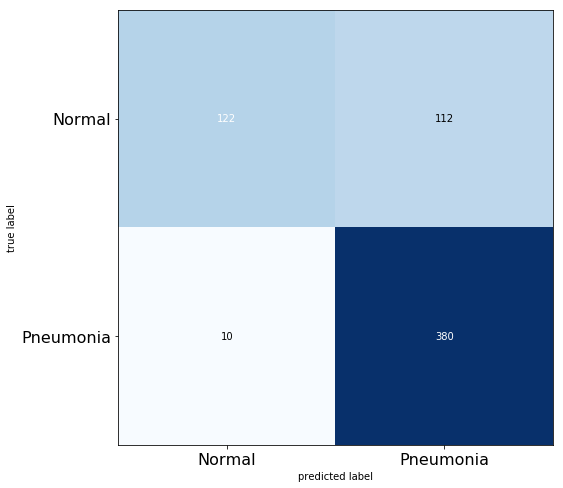

In [98]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [99]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.97
Precision of the model is 0.77
